In [1]:
from IPython.display import HTML, display

# Inject a raw code toggle feature using vanilla JavaScript
display(HTML('''
<script type="text/javascript">
let codeVisible = true;
function toggleCode() {
    let inputs = document.querySelectorAll('div.input');
    for (let i = 0; i < inputs.length; i++) {
        if (codeVisible) {
            inputs[i].style.display = "none";
        } else {
            inputs[i].style.display = "";
        }
    }
    codeVisible = !codeVisible;
}
</script>
<form action="javascript:toggleCode()">
    <input type="submit" value="Toggle Raw Code On/Off">
</form>
'''))



-------
_Faculté des Sciences de Sorbonne Université : Master 1 MF2A - Projet : Bacterial Pattern Formation (2024)_

**Objectifs :** 
- Étudier l'origine du modèle de réaction-diffusion pour la formation de motifs bactériens et définir les différents paramètres 
- Effectuer des simulations numériques des équations de réaction-diffusion
- Analyser les motifs obtenus et, si possible, les comparer avec des observations expérimentales ou des résultats antérieurs

**Ce modèle à été inspiré par 2 articles :**
- <a href="http://localhost:8888/files/Desktop/Mod%C3%A9lisation_bact/ChapterBacteria.pdf"> Bacteria Patterns, Chapter Mathematical Biology
II: Spatial Models and
Biomedical Applications, J. D. Murray, 2000</a>
- <a href="http://localhost:8888/files/Desktop/Mod%C3%A9lisation_bact/bacteries.pdf">  
V. Bucur and B.r Vasiev, arXiv, 2024, Modelling formation of stationary periodic patterns in growing
population of motile bacteria</a>


------------------------

**Mitu Antony**  et  **Le Dimet Lucien**

------------------------


### Import des modules python utiles

In [2]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pylab as plt
from scipy.linalg import eig
from scipy.sparse.linalg import eigs
import time 
from scipy.optimize import curve_fit
import matplotlib as mpl

### Système modèle pour le modèle liquide avec diffusion du stimulant ($s$)

Modèle liquide : 

$$\frac{\partial n}{\partial t} = D_n \nabla^2 n - k_1 \nabla \cdot \left[ \frac{n}{(k_2 + c)^2} \nabla c \right]$$

$$\frac{\partial c}{\partial t} = D_c \nabla^2 c + k_5s \frac{n^2}{k_6 + n^2}.$$

$$\frac{\partial s}{\partial t} = D_s \nabla^2 s$$

<table style="table-layout: fixed; width: 100%;">
    <tr>
        <th style="text-align: center;">Parameter</th>
        <th style="text-align: center;">Value</th>
        <th style="text-align: center;">Source</th>
    </tr>
    <tr>
        <td style="text-align: center;">$k_1$</td>
        <td style="text-align: center; white-space: nowrap;">$3.9 \times 10^{-9} \, M \, cm^2 \, s^{-1}$</td>
        <td style="text-align: center;">Dahlquist et al. 1972</td>
    </tr>
    <tr>
        <td style="text-align: center;">$k_2$</td>
        <td style="text-align: center; white-space: nowrap;">$5 \times 10^{-6} \, M$</td>
        <td style="text-align: center;">Dahlquist et al. 1972</td>
    </tr>
    <tr>
        <td style="text-align: center;">$k_3$</td>
        <td style="text-align: center; white-space: nowrap;">$1.62 \times 10^{-9} \, hr \, ml^{-1} \, cell^{-1}$</td>
        <td style="text-align: center;">Budrene and Berg 1995</td>
    </tr>
    <tr>
        <td style="text-align: center;">$k_4$</td>
        <td style="text-align: center; white-space: nowrap;">$3.5 \times 10^{8} \, cells \, ml^{-1}$</td>
        <td style="text-align: center;">Budrene and Berg 1995</td>
    </tr>
    <tr>
        <td style="text-align: center;">$k_9$</td>
        <td style="text-align: center; white-space: nowrap;">$4 \times 10^{-6} \, M^2$</td>
        <td style="text-align: center;">Budrene and Berg 1995</td>
    </tr>
    <tr>
        <td style="text-align: center;">$D_n$</td>
        <td style="text-align: center; white-space: nowrap;">$2 - 4 \times 10^{-6} \, cm^2 \, s^{-1}$</td>
        <td style="text-align: center;">Berg and Turner 1990; Berg 1983</td>
    </tr>
    <tr>
        <td style="text-align: center;">$D_c$</td>
        <td style="text-align: center; white-space: nowrap;">$8.9 \times 10^{-6} \, cm^2 \, s^{-1}$</td>
        <td style="text-align: center;">Berg 1983</td>
    </tr>
    <tr>
        <td style="text-align: center;">$D_s$</td>
        <td style="text-align: center; white-space: nowrap;">$\approx 9 \times 10^{-6} \, cm^2 \, s^{-1}$</td>
        <td style="text-align: center;">Berg 1983</td>
    </tr>
    <tr>
        <td style="text-align: center;">$n_0$</td>
        <td style="text-align: center; white-space: nowrap;">$10^8 \, cells \, ml^{-1}$</td>
        <td style="text-align: center;">Budrene and Berg 1991</td>
    </tr>
    <tr>
        <td style="text-align: center;">$s_0$</td>
        <td style="text-align: center; white-space: nowrap;">$1 - 3 \times 10^{-3} \, M$</td>
        <td style="text-align: center;">Budrene and Berg 1995</td>
    </tr>
</table>


#### Adimensionnement des équations

Nous obtenons le sytème adimensionné : 
\begin{equation*}
\frac{\partial u}{\partial t} = d_u \nabla^2 u - \alpha \nabla \cdot \left[ \frac{u}{(1 + v)^2} \nabla v \right]
\end{equation*}

\begin{equation*}
\frac{\partial v}{\partial t} = \nabla^2 v + w  \frac{u^2}{\mu + u^2}
\end{equation*}

\begin{equation*}
\frac{\partial w}{\partial t} = d_s \nabla^2 w
\end{equation*}

Avec les constantes : 


$$u = \frac{n}{n_0}, \quad v = \frac{c}{k_2}, \quad w = \frac{s}{s_0}, \quad t^* = \frac{k_5s_0}{k_2} t, \quad x^* = \left(\frac{k_5s_0}{D_ck_2}\right)^{1/2} x,$$

$$d = \frac{D_n}{D_c}, \quad \alpha = \frac{k_1}{D_ck_2}, \quad \mu = \frac{k_6}{n_0^2},\quad  d_{s}=\frac{D_{s}}{D_{c}}$$

## Discrétisation 
Discrétisons dans un premier lieu le Laplacien en à l'aide de différences finies centrées au deuxième ordre : 
$$ \frac{\partial^2 (\cdot)}{\partial x^2} = \frac{(\cdot)_{i+1,j} - 2(\cdot)_{i,j} + (\cdot)_{i-1,j}}{\Delta x^2} $$
Et pour la dérivée première : 
$$ \frac{\partial (\cdot)}{\partial x} = \frac{(\cdot)_{i+1,j} - (\cdot)_{i-1,j}}{2\Delta x} $$
On a donc en deux dimentions : 
$$ \nabla^2 (\cdot)_{i,j} = \frac{(\cdot)_{i+1,j} - 2(\cdot)_{i,j} + (\cdot)_{i-1,j}}{\Delta x^2} + \frac{(\cdot)_{i,j+1} - 2(\cdot)_{i,j} + (\cdot)_{i,j-1}}{\Delta y^2} $$

Pour la discrétisation temporelle nous nous sommes servis du schéma d'Euler explicite : 
$$
\left\{
\begin{aligned}
u_{i,j}^{n+1} &= u_{i,j}^n + \Delta t \, F_u(u_{i,j}^n, v_{i,j}^n), \\
v_{i,j}^{n+1} &= v_{i,j}^n + \Delta t \, F_v(u_{i,j}^n, v_{i,j}^n)\\
w_{i,j}^{n+1} &= w_{i,j}^n + \Delta t \, F_w(u_{i,j}^n, w_{i,j}^n) 
\end{aligned}
\right.
$$

<img src="schéma_cellulesphantomes.png" alt="Diagramme" width="400"/>


Ainsi la discrétisation totale du système est : 

$$
\left\{
\begin{aligned}
\frac{u^{n+1}_{i,j} - u_{i,j}^{n}}{\Delta t} &=  
d_u \cdot \Delta u_{i,j}^{n} 
- \frac{\alpha}{(1+v_{i,j}^{n})^2} \left(
\frac{u_{i+1,j}^{n} - u_{i-1,j}^{n}}{2\Delta x} \cdot 
\frac{v_{i+1,j}^{n} - 2v_{i,j}^{n} + v_{i-1,j}^{n}}{(\Delta x)^2}
+ 
\frac{u_{i,j+1}^{n} - u_{i,j-1}^{n}}{2\Delta y} \cdot 
\frac{v_{i,j+1}^{n} - 2v_{i,j}^{n} + v_{i,j-1}^{n}}{(\Delta y)^2}
\right), 
\\
\frac{v^{n+1}_{i,j} - v_{i,j}^{n}}{\Delta t} &= 
\frac{v_{i+1,j}^{n} - 2v_{i,j}^{n} + v_{i-1,j}^{n}}{(\Delta x)^2} 
+ 
\frac{v_{i,j+1}^{n} - 2v_{i,j}^{n} + v_{i,j-1}^{n}}{(\Delta y)^2} 
+ 
\frac{w_{i,j}^{n} \cdot (u_{i,j}^{n})^2}{\mu + (u_{i,j}^{n})^2}.
\\
\frac{w^{n+1}_{i,j} - w_{i,j}^{n}}{\Delta t} &=
d_s
\left(
\frac{w_{i+1,j}^{n} - 2w_{i,j}^{n} + w_{i-1,j}^{n}}{(\Delta x)^2} 
+ 
\frac{w_{i,j+1}^{n} - 2w_{i,j}^{n} + w_{i,j-1}^{n}}{(\Delta y)^2} 
\right)
\end{aligned}
\right.
$$




## Conditions limites et points "fantômes"

Les conditions limites sur les cotés sont de type "no-flux" c'est à dire des conditions de Neumann homogènes.
Dans un premier temps nous les avons donc approchées par des différences décentrées en amont sur le bord ouest, en aval sur le bord est et de même pour les bords sud et nord. Ce qui donne un schéma de la sorte : 

$$\frac{\partial (\cdot)}{\partial x}_{aval}\simeq \frac{u_{i+1,j}-u_{i,j}}{\Delta x}\\
\frac{\partial (\cdot)}{\partial x}_{amont}\simeq \frac{u_{i,j}-u_{i-1,j}}{\Delta x}$$

Par analyse de troncature, on se rend compte d'une perte d'ordre de précision, en effet pour tout le schéma, les dérivées d'odres 1 et 2  sont approchées à $O(h^2)$ mais avec ces conditions limites là, nous perdons en précision au niveau des bords $O(h)$. 

Ainsi pour remédier à cette perte d'information, nous avons décidé  d'ajouter des cellules "fantômes" qui ne seront pas affichées mais qui serviront à calculer les conditions aux limites. Sur le schéma ci-dessous, elles sont représentées en rouge et nous calculons ainsi les conditions limites à l'aide de différences centrées $O(h^2)$. 


<img src="schéma_cellulesphantomes.png" alt="Diagramme" width="400"/>




## Conservation de la masse 
Dans l'article "Bacteria Patterns, Chapter Mathematical Biology II: Spatial Models and Biomedical Applications, J. D. Murray, 2000" il est stipulé que la quantité totale de bactéries injecté est constante au cours de l'expérience. Ce phénomène est expliqué par le fait qu'il est estimé que le nombre de naissances des bactéries est compensé par le nombre de décès. Ainsi nous avons implémenté une fonction qui "normalise" le nombre de bactéries à chaque itération. De facon mathématique on l'écrirait : 
$$ \int_{\Gamma}^{}uds = 1 \quad \forall t  $$ 
La quantité adimentionnée de bactéries étant 1 à $t=0$. Nous avons donc remplacé cette  intégrale par la fonction ```mass_conservation(u,nx,ny)``` qui grâce à la fonction ```np.sum``` fais "l'intégrale" discrète de u.

 Nous devons tout d'abord établir une configuration numérique, en fonction des paramètres non dimensionnels définis dans "Bacteria Patterns".

In [46]:
def load_config_paramètres():
    
    """ Valeur des paramètres physiques pour le modèle de base """  
    t1 = 0.               # Temps de départ
    tmax = 3.            # Temps de fin
    long = 20.            # Longueur adimensionnée
    larg = 20.            # Largeur adimensionnée
    alpha = 80.           # Paramètre variable [80,90]              
    d = 0.33              # Diffusion des bactéries variable [0.25,0.5]         
    mu = 1.               # Paramètre fixe
    d_s=1                 # Diffusion du stimulant adimentionné
    
    """ Valeur des paramètres numériques pour notre modèle """ 
    nx = 50               # Maillage sur x
    ny = 50               # Maillage sur y
    
    print("Valeur fixée des différents paramètres utilisés")
    print("=================================================================================")
    print ("Temps de départ                               : t0        = {0:.3f}".format(t1))
    print ("Temps de fin                                  : Tmax      = {0:.3f}".format(tmax))
    print ("Longueur adimensionnée                        : Long      = {0:.3f}".format(long))
    print ("Largeur adimensionnée                         : Larg      = {0:.3f}".format(larg))
    print ("Paramètre variable [80,90]                    : alpha     = {0:.3f}".format(alpha))
    print ("Diffusion des bactéries variable [0.25,0.5]   : d         = {0:.3f}".format(d))
    print ("Paramètre fixe                                : mu        = {0:.3f}".format(mu))
    print ("Diffusion du stimulant adimentionné           : Ds        = {0:.3f}".format(d_s))
    print ("Maillage sur x                                : Nx        = {0:.3f}".format(nx))
    print ("Maillage sur y                                : Ny        = {0:.3f}".format(ny))
    return t1, tmax, long, larg, alpha, d, mu, d_s, nx, ny

Charger la configuration étudiée

In [47]:
t1, tmax, long, larg, alpha, d, mu, d_s, nx, ny= load_config_paramètres()

Valeur fixée des différents paramètres utilisés
Temps de départ                               : t0        = 0.000
Temps de fin                                  : Tmax      = 3.000
Longueur adimensionnée                        : Long      = 20.000
Largeur adimensionnée                         : Larg      = 20.000
Paramètre variable [80,90]                    : alpha     = 80.000
Diffusion des bactéries variable [0.25,0.5]   : d         = 0.330
Paramètre fixe                                : mu        = 1.000
Diffusion du stimulant adimentionné           : Ds        = 1.000
Maillage sur x                                : Nx        = 50.000
Maillage sur y                                : Ny        = 50.000


### Comparaison des différentes méthodes de résolution et de leur temps de calcul

#### Etude de la vitesse de calcul de la version indicielle

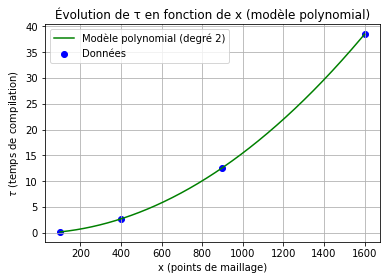

Pour X = 1000000, le modèle polynomial prédit t ≈ 14250408.08 secondes


In [5]:
# Différents temps de calcul en fonction des points de maillage
X = np.array([100, 400, 900, 1600])  # Nombre de points de maillage
Y = np.array([0.20, 2.66, 12.66, 38.48,])  # Temps de compilation en secondes

# Ajustement polynomial
coeffs = np.polyfit(X, Y, deg=2)  # Ajustement avec un polynôme de degré 2
poly_model = np.poly1d(coeffs)  # Modèle polynomial

X_fit = np.linspace(min(X), max(X), 500)  # Générer des points pour la courbe
# Prédictions pour tracer la courbe ajustée
Y_fit_poly = poly_model(X_fit)

# Visualisation
plt.scatter(X, Y, label="Données", color="blue")
plt.plot(X_fit, Y_fit_poly, label=f"Modèle polynomial (degré 2)", color="green")
plt.xlabel("x (points de maillage)")
plt.ylabel(r"$\tau$ (temps de compilation)")
plt.title(u"Évolution de τ en fonction de x (modèle polynomial)")
plt.legend()
plt.grid()
plt.show()

# Prédiction pour X = 10^6
X_test = 1_000_000
Y_pred_poly = poly_model(X_test)
print(f"Pour X = {X_test}, le modèle polynomial prédit t ≈ {Y_pred_poly:.2f} secondes")

L'interpolation est faite à l'aide d'un polynôme de degré 2 car d'après notre condition de stabilité obtenue par analyse de Von Neumann notre pas de temps minimal est $\Delta t \leq \frac{\Delta x^2}{\alpha}$. Ainsi nous remarquons que $\Delta t$ est proportionnel au carré de $\Delta x$.

#### Etude de la vitesse de calcul de la version par section de tableaux

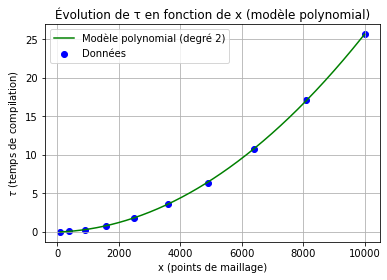

Pour X = 1000000 points de maillage, le modèle polynomial prédit Y ≈ 244401.67 secondes


In [6]:
# Différents temps de calcul en fonction des points de maillage
X = np.array([100, 400, 900, 1600, 2500, 3600, 4900, 6400, 8100, 10000])  # Nombre de points de maillage
Y = np.array([0.01, 0.08, 0.28, 0.75, 1.79, 3.64, 6.38, 10.80, 17.05, 25.61])  # Temps de compilation en secondes

# Ajustement polynomial
coeffs = np.polyfit(X, Y, deg=2)  # Ajustement avec un polynôme de degré 2
poly_model = np.poly1d(coeffs)  # Modèle polynomial

X_fit = np.linspace(min(X), max(X), 500)  # Générer des points pour la courbe
# Prédictions pour tracer la courbe ajustée
Y_fit_poly = poly_model(X_fit)

# Visualisation
plt.scatter(X, Y, label="Données", color="blue")
plt.plot(X_fit, Y_fit_poly, label=f"Modèle polynomial (degré 2)", color="green")
plt.xlabel("x (points de maillage)")
plt.ylabel(r"$\tau$ (temps de compilation)")
plt.title(u"Évolution de τ en fonction de x (modèle polynomial)")
plt.legend()
plt.grid()
plt.show()

# Prédiction pour X = 10^6
X_test = 1_000_000
Y_pred_poly = poly_model(X_test)
print(f"Pour X = {X_test} points de maillage, le modèle polynomial prédit Y ≈ {Y_pred_poly:.2f} secondes")


Nous pouvons remarquer que le temps de compilation est réduit considérament en utilisant les sections de tableau. Dans l'étude ci-dessus, le temps de compilation gangé  pour un maillage ayant un milion de  points est d'un facteur $\approx 60$

### Définition des fonctions utiles à notre résolution

In [ ]:
#Fonction pour normaliser et donc vérifier la conservation de la masse des bactéries dans notre domaine 
import numpy as np

def mass_conservation(U, nx, ny):
    return np.sum(U[2:nx-2, 2:ny-2])


#Fonction pour résoudre notre système d'équations
def résolution_système(t1,u,v,w,alpha,d,ds,dx,dy,dt,affichage):
    for n in range(1,ntmax+1):
        # Tous les dt~=1s, créer la visualisation
        if affichage==1:
            if abs(t1 - round(t1)) < 1e-6 or (t1 - last_print_time >= 1 - 1e-6):
                print(f"\Temps: {t1:.2f} secondes")
            
                # Créer la figure 3D
                fig = plt.figure(figsize=(10,8))
                ax = fig.add_subplot(111, projection='3d')
            
                # Tracer la différence absolue entre u actuel et u initial
                surf = ax.plot_surface(X, Y, u[2:-2,2:-2], cmap="viridis")
            
                ax.set_title(f"Concentration de u à t = {t1:.2f} s")
                ax.set_xlabel("X")
                ax.set_ylabel("")
                ax.set_zlabel("Concentration Adimentionnée")
            
                # Ajouter une barre de couleur
                fig.colorbar(surf, shrink=0.5, aspect=5)
            
                plt.show()
        
        last_print_time = t1        
        
        t1 = n*dt
        #Calcul de U ################################################################
        # Laplacien de u
        laplacien_u = ((u[2:-2, 1:-3] - 2 * u[2:-2, 2:-2] + u[2:-2, 3:-1]) / dx**2 +
                       (u[1:-3, 2:-2] - 2 * u[2:-2, 2:-2] + u[3:-1, 2:-2]) / dy**2)

        # Gradient de v
        grad_v_x = (v[2:-2, 3:-1] - v[2:-2, 1:-3]) / (2 * dx)
        grad_v_y = (v[3:-1, 2:-2] - v[1:-3, 2:-2]) / (2 * dy)

        # Terme div((u * grad(v)) / ((1 + v) ** 2))
        terme_x = ((u[2:-2, 3:-1] * grad_v_x / (1 + v[2:-2, 3:-1])**2 -
                u[2:-2, 1:-3] * grad_v_x / (1 + v[2:-2, 1:-3])**2) / dx)

        terme_y = ((u[3:-1, 2:-2] * grad_v_y / (1 + v[3:-1, 2:-2])**2 -
                u[1:-3, 2:-2] * grad_v_y / (1 + v[1:-3, 2:-2])**2) / dy)

        pertes = alpha * (terme_x + terme_y)

        # Mise à jour de u1
        u1[2:-2, 2:-2] = u[2:-2, 2:-2] + dt * (d * laplacien_u - pertes)

        # Mise à jour de u
        u = u1.copy()
        #Calcul de V ################################################################
        # Laplacien de v
        laplacien_v = ((v[2:-2, 1:-3] - 2 * v[2:-2, 2:-2] + v[2:-2, 3:-1]) / dx**2 +
                   (v[1:-3, 2:-2] - 2 * v[2:-2, 2:-2] + v[3:-1, 2:-2]) / dy**2)

        # Croissance
        croissance = (w[2:-2, 2:-2] * (u[2:-2, 2:-2]**2)) / (mu + (u[2:-2, 2:-2]**2))

        # Mise à jour de v1
        v1[2:-2, 2:-2] = v[2:-2, 2:-2] + dt * (laplacien_v + croissance)

        # Mise à jour de v
        v = v1.copy()

        #Calcul de W ################################################################
        laplacien_w=((w[2:-2, 1:-3] - 2 * w[2:-2, 2:-2] + w[2:-2, 3:-1]) / dx**2 +
                   (w[1:-3, 2:-2] - 2 * w[2:-2, 2:-2] + w[3:-1, 2:-2]) / dy**2)
        #Mise à jour de w1
        w1[2:-2, 2:-2] = w[2:-2, 2:-2] + dt * laplacien_w *d_s
        #Mise à jour de w
        w = w1.copy()
                ##############################################################################
        #conditions limites appliquées à chaque itération
        #Bord Nord et Sud 
        for i in range(1,nx+4-1):
            u[i,1]=(-u[i,2]+u[i,3])*1/dy/2
            u[i,ny+2]=(u[i,ny+3]-u[i,ny+1])*1/dy/2
        #Bord Est et Ouest
        for i in range(1,ny+3):
            u[1,i]=(-u[2,i]+u[3,i])*1/dx/2
            u[nx+2,i]=(u[nx+3,i]-u[nx+1,i])*1/dy/2
    
        #Normalisation
        u=u*1/mass_conservation(u,nx+4,ny+4)
    
    #conditions limites
    for i in range(1,nx+4-1):
        u[i,1]=(-u[i,0]+u[i,2])*1/dy/2
        u[i,ny+2]=(u[i,ny+3]-u[i,ny+1])*1/dy/2



    for i in range(1,ny+3):
        u[1,i]=(-u[0,i]+u[2,i])*1/dx/2
        u[nx+2,i]=(u[nx+3,i]-u[nx+1,i])*1/dy/2
        
    #Correction pour enlever la partie négative des gradients sur le domaine
    for i in range(0, nx+4 ):
        for j in range(0, ny+4 ):
            if u[i,j] < 0:
                u[i,j] = 0#- u[i,j]
            if v[i,j] < 0:
                v[i,j] = 0#- v[i,j]    
     
    #Refaire les calculs en enlevant les gradiants négatifs à l'itération finale car le modèle ne bouge plus dans le domaine 
    if 0.98 > mass_conservation(u,nx,ny) or mass_conservation(u,nx,ny) > 1.02 :
            while 0.98 > mass_conservation(u,nx,ny) or mass_conservation(u,nx,ny) > 1.02 :
                u=u*1/mass_conservation(u,nx,ny)
                # Laplacien de u
                laplacien_u = ((u[2:-2, 1:-3] - 2 * u[2:-2, 2:-2] + u[2:-2, 3:-1]) / dx**2 +
                               (u[1:-3, 2:-2] - 2 * u[2:-2, 2:-2] + u[3:-1, 2:-2]) / dy**2)

                # Gradient de v
                grad_v_x = (v[2:-2, 3:-1] - v[2:-2, 1:-3]) / (2 * dx)
                grad_v_y = (v[3:-1, 2:-2] - v[1:-3, 2:-2]) / (2 * dy)

                # Terme div((u * grad(v)) / ((1 + v) ** 2))
                terme_x = ((u[2:-2, 3:-1] * grad_v_x / (1 + v[2:-2, 3:-1])**2 -
                            u[2:-2, 1:-3] * grad_v_x / (1 + v[2:-2, 1:-3])**2) / dx)

                terme_y = ((u[3:-1, 2:-2] * grad_v_y / (1 + v[3:-1, 2:-2])**2 -
                            u[1:-3, 2:-2] * grad_v_y / (1 + v[1:-3, 2:-2])**2) / dy)

                pertes = alpha * (terme_x + terme_y)

                # Mise à jour de u1
                u1[2:-2, 2:-2] = u[2:-2, 2:-2] + dt * (d * laplacien_u - pertes)

                # Mise à jour de u
                u = u1.copy()

                # Laplacien de v
                laplacien_v = ((v[2:-2, 1:-3] - 2 * v[2:-2, 2:-2] + v[2:-2, 3:-1]) / dx**2 +
                               (v[1:-3, 2:-2] - 2 * v[2:-2, 2:-2] + v[3:-1, 2:-2]) / dy**2)

                # Croissance
                croissance = (w[2:-2, 2:-2] * (u[2:-2, 2:-2]**2)) / (mu + (u[2:-2, 2:-2]**2))

                # Mise à jour de v1
                v1[2:-2, 2:-2] = v[2:-2, 2:-2] + dt * (laplacien_v + croissance)

                # Mise à jour de v
                v = v1.copy()
                laplacien_w=((w[2:-2, 1:-3] - 2 * w[2:-2, 2:-2] + w[2:-2, 3:-1]) / dx**2 +
                               (w[1:-3, 2:-2] - 2 * w[2:-2, 2:-2] + w[3:-1, 2:-2]) / dy**2)
                # Mise à jour de w1
                w1[2:-2, 2:-2] = w[2:-2, 2:-2] + dt * laplacien_w *d_s
                #Mise à jour de w
                w = w1.copy()
    #Normalisation
    u=u*1/mass_conservation(u,nx+4,ny+4)
    return u , mass_conservation(u,nx,ny)

## Étude de la précision du maillage
Pour  une longueur et largeur adimentionnés de 20, nous alons étudier la précision du maillage. Il n'existe pas de solution analytique à notre problème. Pour ce faire nous avons défini la fonction ```mass_conservation(u,nx,ny)```. La somme des bactéries étant constante $\forall t$ nous allons ainsi mesurer la précision de celle-ci pour différentes valeurs de maillage. 
Definissons la valeur d'erreur absolue comme : 
$$
\text{Err} = \left| u_0 - \text{mass\_conservation} \right|
$$

Avec $u_0$ la quantitée initale adimentionnée de bactéries, dans notre cas égale à 1.

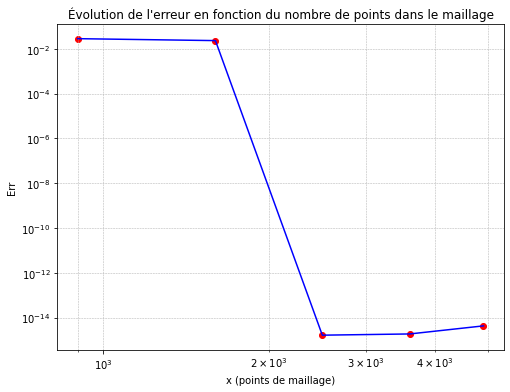

In [8]:
# Différentes valeurs de mass_conservation en fonction des points de maillage
X = np.array([ 900, 1600, 2500, 3600, 4900])  # Nombre de points de maillage
Y = np.array([ 1.0285448337609278, 1.0233882941266135, 0.9999999999999983, 0.9999999999999981, 0.9999999999999957]) # Valeur de mass_conservation

plt.figure(figsize=(8, 6))
plt.plot(X, np.abs(1-Y), color="blue") 
plt.scatter(X, np.abs(1-Y), color="red")  
plt.yscale('log')  
plt.xscale('log') 
plt.xlabel("x (points de maillage)")
plt.ylabel("Err")
plt.title("Évolution de l'erreur en fonction du nombre de points dans le maillage")
plt.grid(which="both", linestyle='--', linewidth=0.5) 
plt.show()


On peut remarque qu'à partir du maillage $50 \ast 50$ la précision du calcul tombe à $10^{-16}$ ce qui correspond à l'erreur machine.

### Calcul / affichage des résultats à t = $ t_{max}$ et comparaison avec les résultats de l'étude


#### Répartition alléatoire des batéries à t = 0

In [38]:
# Calcul de quantites utiles
dx = long/nx
dy = larg/ny
dt = dx * dx / (4 * d * alpha) #CFL 
epsilon=10e-1
ntmax = int(round(tmax/dt))

# Geometrie
x = np.linspace(-long/2,long/2,nx);
y = np.linspace(-larg/2,larg/2,ny);
X, Y = np.meshgrid(x, y,indexing = 'ij')

# Initialisation
u  =  np.zeros((nx+4,nx+4)) 
x  =  np.zeros((nx+4,nx+4))
u1 =  np.zeros((nx+4,nx+4))
v  =  np.zeros((nx+4,nx+4))
v1 =  np.zeros((nx+4,nx+4))
w  =  np.ones((nx+4,nx+4))
w1 =  np.ones((nx+4,nx+4))

#Répartition alléatoire des batéries
x = np.random.randn(nx+4,ny+4)
u=1/mass_conservation(x,nx+4,ny+4)*x

print('Quantité de stimulant départ =',mass_conservation(w,nx+4,ny+4))
print('Répartition de la masse de bactéries initiale =',mass_conservation(u,nx+4,ny+4))
# Debut boucle temporelle
start = time.time()

u = résolution_système(t1,u,v,w,alpha,d,d_s,dx,dy,dt,0)[0]

end = time.time()
print( "Temps de calcul %.2f seconds pour tmax=3s et un maillage 50*50" % (end-start) )
print('Répartition de la masse de bactéries finale =',mass_conservation(u,nx+4,ny+4))
print('Quantité de stimulant restant =',mass_conservation(w,nx+4,ny+4))

Quantité de stimulant départ = 2500.0
Répartition de la masse de bactéries initiale = 1.0000000000000002
Temps de calcul 0.84 seconds pour tmax=3s et un maillage 50*50
Répartition de la masse de bactéries finale = 1.170549563369912
Quantité de stimulant restant = 2500.0


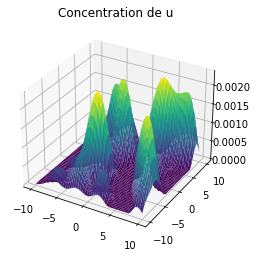

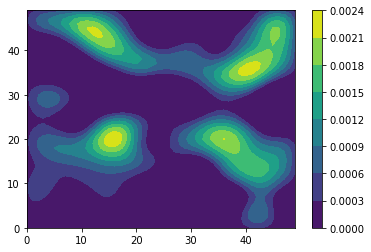

In [ ]:
fig = plt.figure(1)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y,u[2:-2,2:-2], cmap='viridis')
ax.set_title("Concentration de u à t=3s")
fig2 = plt.figure(2)
plt.rcParams['image.cmap'] = 'viridis'
plt.contourf(u[2:-2,2:-2])
plt.colorbar()
plt.show()

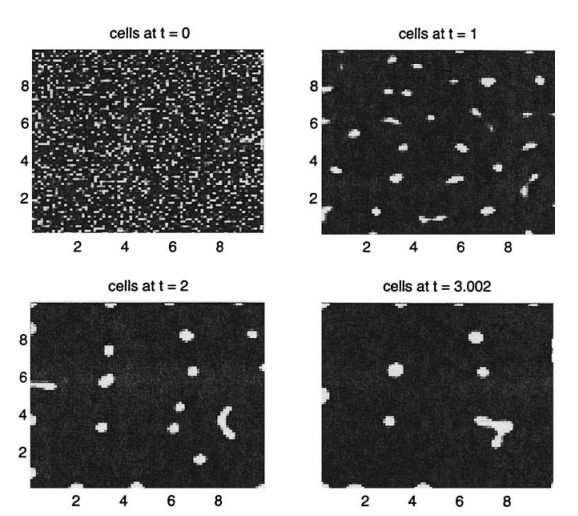

Notre simulation nous renvoie exactement les mêmes résultats que ceux présents dans l'étude. Avec une répartition de départ aléatoire, une répartition du stimulant uniforme, les bactéries s'agglomèrent avec l'avancée du temps.

#### Répartition centrée des batéries à t = 0

In [44]:
# Calcul de quantites utiles
dx = long/nx
dy = larg/ny
tmax = 10.
dt = dx * dx / (4 * d * alpha) #CFL 
epsilon=10e-1
ntmax = int(round(tmax/dt))

# Geometrie
x = np.linspace(-long/2,long/2,nx);
y = np.linspace(-larg/2,larg/2,ny);
X, Y = np.meshgrid(x, y,indexing = 'ij')

# Initialisation
u  =  np.zeros((nx+4,nx+4)) 
x  =  np.zeros((nx+4,nx+4))
u1 =  np.zeros((nx+4,nx+4))
v  =  np.zeros((nx+4,nx+4))
v1 =  np.zeros((nx+4,nx+4))
w  =  np.ones((nx+4,nx+4))
w1 =  np.ones((nx+4,nx+4))

##Répartition des bactéries carrée au centre de taille nx+4/4
x = np.zeros((nx+4, ny+4))
center_x = (nx+4) // 2
center_y = (ny+4) // 2
side_length = (nx+4) // 4

#petit carré
x[center_x :center_x + 1,
  center_y :center_y + 1] = 1
total = np.sum(x)
u = 1 / total * x

print('Quantité de stimulant départ =',mass_conservation(w,nx+4,ny+4))
print('Répartition de la masse de bactéries initiale =',mass_conservation(u,nx+4,ny+4))
# Debut boucle temporelle
start = time.time()

u = résolution_système(t1,u,v,w,alpha,d,d_s,dx,dy,dt,0)[0]

end = time.time()
print( "Temps de calcul %.2f seconds pour tmax=10s et un maillage 50*50" % (end-start) )
print('Répartition de la masse de bactéries finale =',mass_conservation(u,nx+4,ny+4))
print('Quantité de stimulant restant =',mass_conservation(w,nx+4,ny+4))

Quantité de stimulant départ = 2500.0
Répartition de la masse de bactéries initiale = 1.0
Temps de calcul 3.26 seconds pour tmax=10s et un maillage 50*50
Répartition de la masse de bactéries finale = 1.0
Quantité de stimulant restant = 2500.0


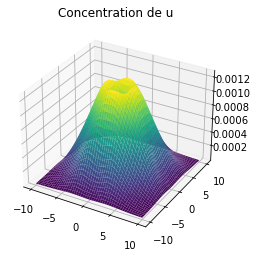

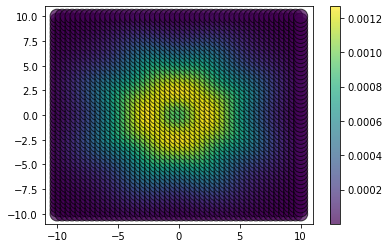

In [45]:
fig = plt.figure(1)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y,u[2:-2,2:-2], cmap="viridis")
ax.set_title("Concentration de u")
fig2 = plt.figure(2)
plt.scatter(X, Y,
           linewidths=1, alpha=.7,
           edgecolor='k',
           s = 200,
           c=u[2:-2,2:-2])
plt.colorbar()
plt.show()

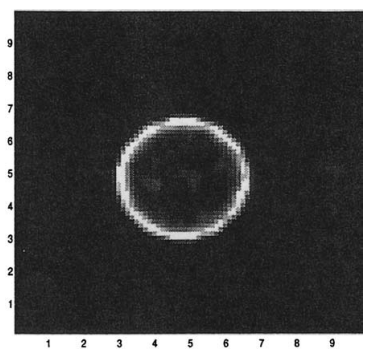

D'après l'étude, "Au fil du temps, les simulations indiquent que le rayon de l'anneau diminue. Finalement, le rayon
finit par devenir si petit que l'anneau est essentiellement constitué d'un seul point." ce qui correspond exactement au comportement de notre propre simulation. Nous pouvons donc affirmer que nos résultats sont cohérents avec ceux de la littérature.

### Variation des paramètres adimensionnés $\alpha$ et $d$

Attention temps de calcul long.

In [13]:
alpha = np.array([81, 82, 83, 84, 85, 86, 87, 88, 89, 90])  #[80,90] 
d = np.array([0.25, 0.29, 0.31, 0.33, 0.35, 0.37, 0.39, 0.41, 0.43, 0.45, 0.47, 0.49])  #[0.25,0.5] 
'''
for i in range(0, 12):
    #print(i)
    for j in range(0,10): 
        #print(j)
        # Initialisation
        u  =  np.zeros((nx+4,nx+4)) 
        x  =  np.zeros((nx+4,nx+4))
        u1 =  np.zeros((nx+4,nx+4))
        v  =  np.zeros((nx+4,nx+4))
        v1 =  np.zeros((nx+4,nx+4))
        w  =  np.ones((nx+4,nx+4))
        w1 =  np.ones((nx+4,nx+4))

        ##Répartition des bactéries carrée au centre de taille nx+4/4
        x = np.zeros((nx+4, ny+4))
        center_x = (nx+4) // 2
        center_y = (ny+4) // 2
        side_length = (nx+4) // 4

        #petit carré
        x[center_x :center_x + 1,
          center_y :center_y + 1] = 1
        total = np.sum(x)
        u = 1 / total * x

        u = résolution_système(t1,u,v,w,alpha[j],d[i],d_s,dx,dy,dt,0)[0]
        
        # Afficher les figures pour trouver les patterns 
#        fig2 = plt.figure(2)
 #       plt.scatter(X, Y,
  #                 linewidths=1, alpha=.7,
   #                edgecolor='k',
    #               s = 200,
     #              c=u[2:-2,2:-2])
      #  plt.show()

print('Fin')
'''

"\nfor i in range(0, 12):\n    #print(i)\n    for j in range(0,10): \n        #print(j)\n        # Initialisation\n        u  =  np.zeros((nx+4,nx+4)) \n        x  =  np.zeros((nx+4,nx+4))\n        u1 =  np.zeros((nx+4,nx+4))\n        v  =  np.zeros((nx+4,nx+4))\n        v1 =  np.zeros((nx+4,nx+4))\n        w  =  np.ones((nx+4,nx+4))\n        w1 =  np.ones((nx+4,nx+4))\n\n        ##Répartition des bactéries carrée au centre de taille nx+4/4\n        x = np.zeros((nx+4, ny+4))\n        center_x = (nx+4) // 2\n        center_y = (ny+4) // 2\n        side_length = (nx+4) // 4\n\n        #petit carré\n        x[center_x :center_x + 1,\n          center_y :center_y + 1] = 1\n        total = np.sum(x)\n        u = 1 / total * x\n\n        u = résolution_système(t1,u,v,w,alpha[j],d[i],d_s,dx,dy,dt,0)[0]\n        \n        # Afficher les figures pour trouver les patterns \n#        fig2 = plt.figure(2)\n #       plt.scatter(X, Y,\n  #                 linewidths=1, alpha=.7,\n   #              

### Résultats des simulations - Espace de formation de patterns

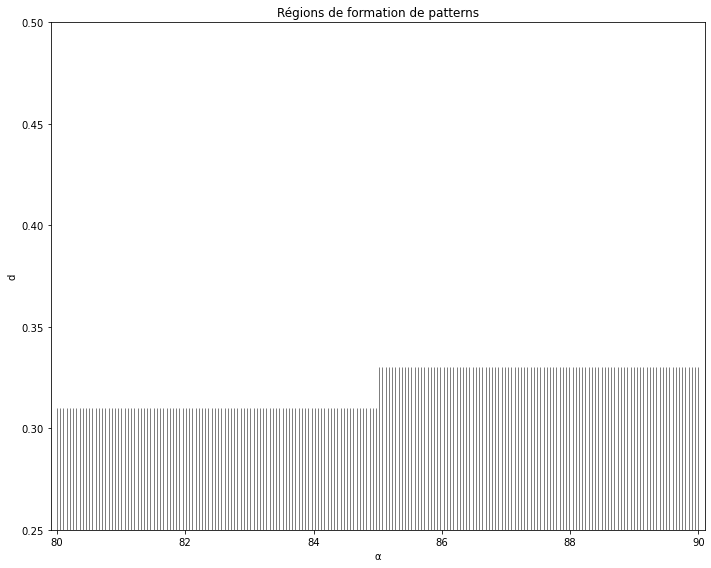

In [14]:
def create_pattern():
    # Création des axes
    alpha = np.linspace(80, 90, 200)
    
    def upper_bound(x):
        # Utilisation d'intervalles au lieu de valeurs exactes
        if  x < 85:
            return 0.31
        elif 85 <= x :
            return 0.33
        else:
            return 0.25
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Tracer les lignes verticales
    for a in alpha:
        if a <= 90:
            plt.vlines(a, ymin=0.25, ymax=upper_bound(a), colors='black', linewidth=0.5)
    
    plt.xlim(79.9, 90.1)
    plt.ylim(0.25, 0.50)
    plt.xlabel('α')
    plt.ylabel('d')
    plt.title('Régions de formation de patterns')
    plt.grid(False)
    
    plt.tight_layout()
    return fig

# Création et affichage du graphique
fig = create_pattern()
plt.show()

Pour ce premier modèle, la zone hachurée représente la zone de formation de patterns. Si on garde nos paramètres dans cette zone on pourra donc en observer.

# Modèle complet - Comparaison de nos résultats avec ceux de l'étude
Considérons maintenant le modèle compet et biologiquement correct ci-dessous : 



\begin{cases} 
\displaystyle \frac{\partial u}{\partial t} = d_u \nabla^2 u -  \alpha \nabla  \left[ \frac{u}{(1 + v)^2} \nabla v \right] + \rho u \left(\delta \frac{w^2}{1 + w^2} - u\right)
 \\[1.5em]
\displaystyle \frac{\partial v}{\partial t} = \nabla^2 v + \beta w \frac{u^2}{\mu + u^2}-uv
\end{cases}




Avec : $$\rho = \left[\frac{\sqrt{\alpha\beta(\mu - \delta^2)}}{\mu + \delta(\beta + \delta)} - \sqrt{d_u}\right]^2$$

La consommation du stimulant par les batéries est négligeable par rapport à la quantitée de stimulant déposé, de plus sa diffusion est beaucoup plus rapide que celle de nos bactéries. La $3^e$ équation rendant compte de l'évolution du stimulant peut donc être négligée et ce dernier considéré comme une constante.

In [48]:
def load_config_nouv_paramètres():
    
    """ Valeur des paramètres physiques pour le modèle de base """  
    delta = 20.           # Paramètre fixe
    beta = 0.2            # Paramètre fixe
    alpha = 2.25          # Paramètre fixe              
    d_u = 0.25            # Paramètre fixe        
    mu = 1.               # Paramètre fixe
    rho = 0.01            # Paramètre fixe
    
    print("Valeur fixée des différents paramètres utilisés")
    print("=================================================================================")
    print ("Delta                                           : delta  = {0:.3f}".format(delta))
    print ("Beta                                            : beta   = {0:.3f}".format(beta))
    print ("Alpha                                           : alpha  = {0:.3f}".format(alpha))
    print ("Diffusion des bactéries                         : d_u    = {0:.3f}".format(d_u))
    print ("Mu                                              : mu     = {0:.3f}".format(mu))
    print ("Rho                                             : rho    = {0:.3f}".format(rho))
    return delta, beta, alpha, d_u, mu, rho

In [ ]:
t1, tmax, long, larg, alpha, d, mu, d_s, nx, ny= load_config_paramètres()
delta, beta, alpha, d_u, mu, rho = load_config_nouv_paramètres()

Valeur fixée des différents paramètres utilisés
Delta                                           : delta  = 20.000
Beta                                            : beta   = 0.200
Alpha                                           : alpha  = 2.250
Diffusion des bactéries                         : d_u    = 0.250
Mu                                              : mu     = 1.000
Rho                                             : rho    = 0.010


In [ ]:
#Fonction pour résoudre notre système d'équations
def résolution_système_final(t1,u,v,w,delta, beta, alpha, d_u, mu, rho,ds,dx,dy,dt,affichage):
    for n in range(1,ntmax+1):
        # Tous les dt~=1s, créer la visualisation
        if affichage==1:
            if abs(t1 - round(t1)) < 1e-6 or (t1 - last_print_time >= 1 - 1e-6):
                print(f"\Temps: {t1:.2f} secondes")
            
                # Créer la figure 3D
                fig = plt.figure(figsize=(10,8))
                ax = fig.add_subplot(111, projection='3d')
            
                # Tracer la différence absolue entre u actuel et u initial
                surf = ax.plot_surface(X, Y, u[2:-2,2:-2], cmap="viridis")
            
                ax.set_title(f"Concentration de u à t = {t1:.2f} s")
                ax.set_xlabel("X")
                ax.set_ylabel("")
                ax.set_zlabel("Concentration Adimentionnée")
            
                # Ajouter une barre de couleur
                fig.colorbar(surf, shrink=0.5, aspect=5)
            
                plt.show()
        
        last_print_time = t1        
        
        t1 = n*dt
        #Calcul de U ################################################################
        # Laplacien de u
        laplacien_u = ((u[2:-2, 1:-3] - 2 * u[2:-2, 2:-2] + u[2:-2, 3:-1]) / dx**2 +
                       (u[1:-3, 2:-2] - 2 * u[2:-2, 2:-2] + u[3:-1, 2:-2]) / dy**2)

        # Gradient de v
        grad_v_x = (v[2:-2, 3:-1] - v[2:-2, 1:-3]) / (2 * dx)
        grad_v_y = (v[3:-1, 2:-2] - v[1:-3, 2:-2]) / (2 * dy)

        # Terme div((u * grad(v)) / ((1 + v) ** 2))
        terme_x = ((u[2:-2, 3:-1] * grad_v_x / (1 + v[2:-2, 3:-1])**2 -
                u[2:-2, 1:-3] * grad_v_x / (1 + v[2:-2, 1:-3])**2) / dx)

        terme_y = ((u[3:-1, 2:-2] * grad_v_y / (1 + v[3:-1, 2:-2])**2 -
                u[1:-3, 2:-2] * grad_v_y / (1 + v[1:-3, 2:-2])**2) / dy)

        pertes = alpha * (terme_x + terme_y)

        # Mise à jour de u1
        u1[2:-2, 2:-2] = u[2:-2, 2:-2] + dt * (d_u * laplacien_u - pertes  + rho*u[2:-2, 2:-2]*(delta*(((w[2:-2, 2:-2]**2)/(1+(w[2:-2, 2:-2]**2)))-u[2:-2, 2:-2])))                    

        # Mise à jour de u
        u = u1.copy()
        #Calcul de V ################################################################
        # Laplacien de v
        laplacien_v = ((v[2:-2, 1:-3] - 2 * v[2:-2, 2:-2] + v[2:-2, 3:-1]) / dx**2 +
                   (v[1:-3, 2:-2] - 2 * v[2:-2, 2:-2] + v[3:-1, 2:-2]) / dy**2)

        # Croissance
        croissance = (beta*w[2:-2, 2:-2] * (u[2:-2, 2:-2]**2)) / (mu + (u[2:-2, 2:-2]**2))

        # Mise à jour de v1
        v1[2:-2, 2:-2] = v[2:-2, 2:-2] + dt * (laplacien_v + croissance - u[2:-2, 2:-2]*v[2:-2, 2:-2])

        # Mise à jour de v
        v = v1.copy()
        ##############################################################################
        #conditions limites appliquées à chaque itération
        #Bord Nord et Sud 
        for i in range(1,nx+4-1):
            u[i,1]=(-u[i,2]+u[i,3])*1/dy/2
            u[i,ny+2]=(u[i,ny+3]-u[i,ny+1])*1/dy/2
        #Bord Est et Ouest
        for i in range(1,ny+3):
            u[1,i]=(-u[2,i]+u[3,i])*1/dx/2
            u[nx+2,i]=(u[nx+3,i]-u[nx+1,i])*1/dy/2
    
        #Normalisation
        u=u*1/mass_conservation(u,nx+4,ny+4)
    #Correction pour enlever la partie négative des gradients sur le domaine
    for i in range(0, nx+4 ):
        for j in range(0, ny+4 ):
            if u[i,j] < 0:
                u[i,j] = 0#- u[i,j]
            if v[i,j] < 0:
                v[i,j] = 0#- v[i,j]
        
   
    return u , mass_conservation(u,nx,ny)

Pour ce modèle, dans l'étude, les bactéries sont déposées en un point à l'extrémité bas-gauche du domaine. Pour pouvoir comparer nous résulats nous avons décidé d'utiliser la même approche.

In [ ]:
# Calcul de quantites utiles
tmax = 50.
long = 100.
larg = 100.
dx = long/nx
dy = larg/ny
d = 0.33
dt = dx * dx / (4 * d * alpha) #CFL 
epsilon=10e-1
ntmax = int(round(tmax/dt))

# Geometrie
x = np.linspace(-long/2,long/2,nx);
y = np.linspace(-larg/2,larg/2,ny);
X, Y = np.meshgrid(x, y,indexing = 'ij')

# Initialisation
t1 = 0
u  =  np.zeros((nx+4,nx+4)) 
x  =  np.zeros((nx+4,nx+4))
u1 =  np.zeros((nx+4,nx+4))
v  =  np.zeros((nx+4,nx+4))
v1 =  np.zeros((nx+4,nx+4))
w  =  np.ones((nx+4,nx+4))
w1 =  np.ones((nx+4,nx+4))

#Répartition bas gauche
x = np.zeros((nx+4, ny+4))
bas_x = 2
bas_y = 2
x[bas_x,
  bas_y] = 1
total = np.sum(x)
u = 1 / total * x

print('Quantité de stimulant départ =',mass_conservation(w,nx+4,ny+4))
print('Répartition de la masse de bactéries initiale =',mass_conservation(u,nx+4,ny+4))
# Debut boucle temporelle
start = time.time()

u = résolution_système_final(t1,u,v,w,delta, beta, alpha, d_u, mu, rho,d_s,dx,dy,dt,0)[0]

end = time.time()
print( "Temps de calcul %.2f seconds pour tmax=50s et un maillage 50*50" % (end-start) )
print('Répartition de la masse de bactéries finale =',mass_conservation(u,nx+4,ny+4))
print('Quantité de stimulant restant =',mass_conservation(w,nx+4,ny+4))

Quantité de stimulant départ = 2500.0
Répartition de la masse de bactéries initiale = 1.0
Temps de calcul 0.02 seconds pour tmax=50s et un maillage 50*50
Répartition de la masse de bactéries finale = 1.1277439224628443
Quantité de stimulant restant = 2500.0


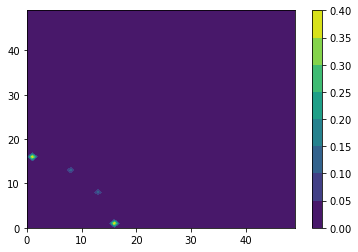

In [68]:
# Affichage des résultats pour u
fig3 = plt.figure(3)
plt.contourf(u[2:-2,2:-2])
plt.colorbar()
plt.show()

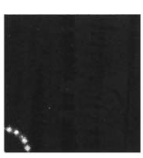

Pour ce modèle, nous avons obtenu une courbe similaire dans le coin inférieur gauche au même instant ($t=50s$), bien que la forme soit légèrement plus diffuse. Sur leur graphique aucune échelle n'est précisée, on peut donc déduire que les différences observées sont dues à cela. On observe néanmoins une tendance claire à une organisation en quart de cercle. Nos résulats semblent donc cohérents avec ceux de l'étude.

# Conclusion
- Une approche mathématique réussie : obtention de résultats très proches de l'étude. 
- Ce projet a permis de mieux comprendre comment les motifs bactériens se forment grâce à un modèle basé sur des équations de réaction-diffusion. Les simulations montrent clairement l'importance des paramètres biologiques et physiques dans l’apparition de ces motifs.

Pistes d'amélioration : 
- Passer en schéma d'intérgration temporelle implicite (Cranck Nicolson ou Euler Implicite) pour obtenir des figures à temps très longs $\simeq 400 s$ et à maillages plus rafinés. 
- Modéliser les "branching patterns" dont le modèle non linéaire est situé à la fin de 'Bacteria Patterns"
- Pour aller plus loin, il serait intéressant de valider ces modèles avec des données expérimentales.